#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env
from sqlalchemy import text, create_engine

# Exercise

- Save this work in your anomaly-detection-exercises repository in a file named discrete_anomaly_detection.ipynb.

- Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [2]:
url = env.get_db_url('logs')

In [3]:
df = pd.read_sql('select * from api_access', url)

In [5]:
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [6]:
df.entry[0]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/sales?page=81 HTTP/1.1" 200 512495 "-" "python-requests/2.21.0"'

In [7]:
df.entry[0].split()

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [8]:
parts = df.entry[0].split()
parts

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [10]:
# function to deal with parsing one entry in our log data
#this function works on one string
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).strip('"')
    return pd.Series(output)

In [11]:
df = df.entry.apply(parse_log_entry)

In [12]:
df

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13969,97.105.19.58,17/Apr/2019 12:55:12,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0
13970,97.105.19.58,17/Apr/2019 12:55:12,GET,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0
13971,97.105.19.58,17/Apr/2019 12:55:13,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0
13972,97.105.19.58,17/Apr/2019 12:55:13,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0


In [13]:
df['size_mb'] = df['size'] / 1024 / 1024

In [14]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [16]:
df.ip.value_counts()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
54.145.52.184         1
3.92.201.136          1
35.174.209.2          1
34.229.70.250         1
54.172.14.223         1
34.207.64.242         1
3.88.129.158          1
52.91.30.150          1
52.90.165.200         1
45.23.250.16          1
Name: ip, dtype: int64

In [17]:
ip_df1 = df.ip.value_counts().reset_index().rename(columns={'index':'ip', 'ip':'cnt'})
ip_df1

,ip,cnt
0,97.105.19.58,11998
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21
5,68.201.219.223,21
6,70.121.214.34,2
7,52.87.230.102,2
8,35.175.171.137,2
9,54.145.52.184,1


In [18]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [21]:
ip_df2 = df.ip.value_counts(normalize=True).reset_index().rename(columns={'index':'ip','ip':'percent'})
ip_df2

,ip,percent
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503
5,68.201.219.223,0.001503
6,70.121.214.34,0.000143
7,52.87.230.102,0.000143
8,35.175.171.137,0.000143
9,54.145.52.184,0.000072


In [22]:
ip_df = pd.merge(ip_df1, ip_df2, how='inner', on='ip')
ip_df.head()

,ip,cnt,percent
0,97.105.19.58,11998,0.858595
1,173.173.113.51,1059,0.075784
2,72.181.113.170,613,0.043867
3,72.181.105.81,246,0.017604
4,24.26.242.9,21,0.001503


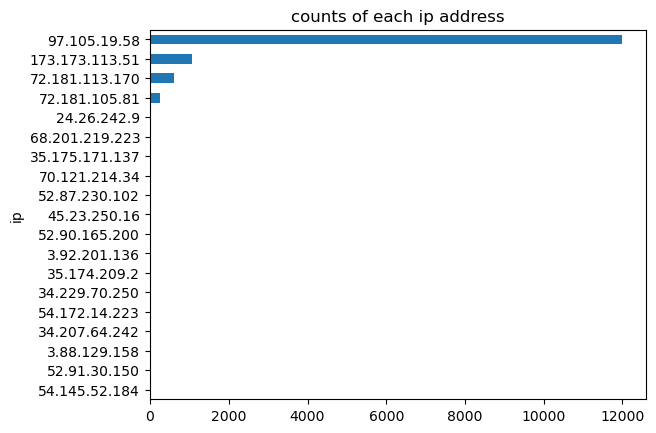

In [23]:
ip_df.set_index('ip').cnt.sort_values().plot.barh()
plt.title('counts of each ip address')
plt.show()

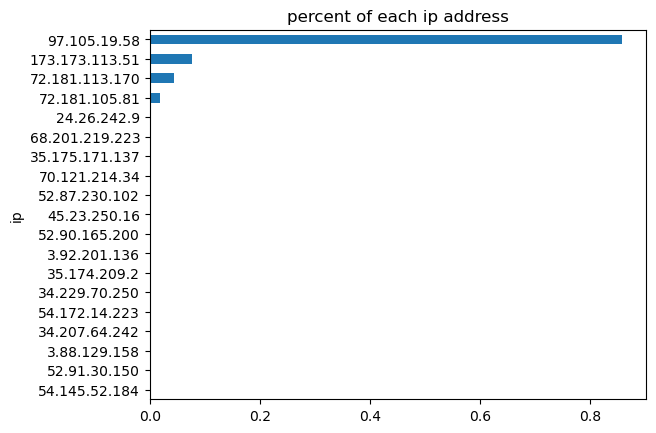

In [24]:
ip_df.set_index('ip').percent.sort_values().plot.barh()
plt.title('percent of each ip address')
plt.show()

In [27]:
df.request_path.value_counts()

/api/v1/sales?page=2                 709
/api/v1/items                        464
/api/v1/items?page=2                 291
/api/v1/items?page=3                 219
/api/v1/stores                       162
                                    ... 
/api/v1/items?page=0                   1
/api/v1/stores?page=999                1
/api/v1/stores?page=2                  1
/api/v1/stores?page=666                1
/api/v1/items/api/v1/items?page=3      1
Name: request_path, Length: 218, dtype: int64

In [35]:
df.size_mb

0        0.488753
1        0.003396
2        0.486472
3        0.486377
4        0.488246
           ...   
13969    0.487846
13970    0.487519
13971    0.488072
13972    0.486504
13973    0.486532
Name: size_mb, Length: 13974, dtype: float64

In [41]:
df.groupby(['ip','size_mb']).size()

ip              size_mb 
173.173.113.51  0.000040     1
                0.000332     1
                0.001266    54
                0.001704    62
                0.003396    64
                            ..
97.105.19.58    0.489018    53
                0.489261    57
                0.489460    52
                0.489533    55
                0.489937    56
Length: 745, dtype: int64

In [42]:
p_a_and_b = df.groupby(['ip','size_mb']).size() / len(df)
p_a_and_b

ip              size_mb 
173.173.113.51  0.000040    0.000072
                0.000332    0.000072
                0.001266    0.003864
                0.001704    0.004437
                0.003396    0.004580
                              ...   
97.105.19.58    0.489018    0.003793
                0.489261    0.004079
                0.489460    0.003721
                0.489533    0.003936
                0.489937    0.004007
Length: 745, dtype: float64

In [48]:
# p_a_and_b.sort_index() / 

(df.ip.value_counts() / len(df)).sort_index()

173.173.113.51    0.075784
24.26.242.9       0.001503
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001503
70.121.214.34     0.000143
72.181.105.81     0.017604
72.181.113.170    0.043867
97.105.19.58      0.858595
Name: ip, dtype: float64

In [50]:
p_b = df.groupby('ip').size() / len(df)

In [51]:
p_a_and_b / p_b

ip              size_mb 
173.173.113.51  0.000040    0.000944
                0.000332    0.000944
                0.001266    0.050992
                0.001704    0.058546
                0.003396    0.060434
                              ...   
97.105.19.58    0.489018    0.004417
                0.489261    0.004751
                0.489460    0.004334
                0.489533    0.004584
                0.489937    0.004667
Length: 745, dtype: float64

In [52]:
df.groupby('ip').size_mb.value_counts(normalize=True).rename('prob').reset_index()


,ip,size_mb,prob
0,173.173.113.51,0.003396,0.060434
1,173.173.113.51,0.001704,0.058546
2,173.173.113.51,0.003489,0.058546
3,173.173.113.51,0.001266,0.050992
4,173.173.113.51,0.486502,0.013220
...,...,...,...
740,97.105.19.58,0.000120,0.000083
741,97.105.19.58,0.265481,0.000083
742,97.105.19.58,0.312356,0.000083
743,97.105.19.58,0.327981,0.000083
